<a href="https://colab.research.google.com/github/SaraLatif99/pytorch_transfer_learning_image_classification/blob/master/VGG16_On_corel15K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating and Using a Fixed Feature Extractor



In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
plt.ion()  



In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

trainset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Datasets/corel1500/train',transform=transform)
testset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Datasets/corel1500/test', transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [12]:
for images, labels in trainloader:
  print(images.size(), labels.size())
  break

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [0]:
model = models.vgg16(pretrained = True)

In [14]:
model.features #Feature Section of model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [15]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [0]:
#First thing we wnat to do when treating our network as a fixed feature classifier is to freeze the network, so all we
#is to grab all the parameters and set the requires grad to false
for param in model.parameters():  
  param.requires_grad = False

In [0]:
#Now we want to remove the last fully connected layer and then treat the rest of the network as a fixed feature extractor
#We'll then add  linear classifier like softmax that we'll train on
#index [-1 ] to get to the last layer
model.classifier[-1]  = nn.Sequential(
                          nn.Linear(in_features= 4096, out_features= 15),
                          nn.LogSoftmax(dim = 1)  
)

In [18]:
#taking a look at classifier again
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=15, bias=True)
    (1): LogSoftmax()
  )
)

In [0]:
# we are using NLL Loss as our classifier

criterion = nn.NLLLoss()


In [0]:
#Autograd is used to automatically calculating the gradients of the tensors, tensor are building block of NN

In [0]:
#Fixed Feature Extractor

# Training a Fixed Feature Extractor

In [0]:
from torch.optim import Adam

model = model.to(device)  #Sending model to GPU
optimizer = Adam(model.parameters())  #We are adding our model parameters as argument to Adam Optimizer

In [23]:
#Training Fixed Feature Extractor for 15 epochs
num_epochs = 15
batch_loss = 0
cum_epoch_loss = 0 #cumulative loss for each batch

for e in range(num_epochs):
  cum_epoch_loss = 0
  
  for batch, (images, labels) in enumerate(trainloader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)}) : Batch loss : {loss.item()}')
    
  print(f'Training loss : {batch_loss/len(trainloader)}')  
    

Epoch(0/15 : Batch number(1/17) : Batch loss : 0.018998272716999054
Epoch(0/15 : Batch number(2/17) : Batch loss : 0.009061073884367943
Epoch(0/15 : Batch number(3/17) : Batch loss : 0.006461292505264282
Epoch(0/15 : Batch number(4/17) : Batch loss : 0.008832675404846668
Epoch(0/15 : Batch number(5/17) : Batch loss : 0.015594028867781162
Epoch(0/15 : Batch number(6/17) : Batch loss : 0.0072093261405825615
Epoch(0/15 : Batch number(7/17) : Batch loss : 0.006676756776869297
Epoch(0/15 : Batch number(8/17) : Batch loss : 0.011187358759343624
Epoch(0/15 : Batch number(9/17) : Batch loss : 0.010794644244015217
Epoch(0/15 : Batch number(10/17) : Batch loss : 0.013505974784493446
Epoch(0/15 : Batch number(11/17) : Batch loss : 0.015112532302737236
Epoch(0/15 : Batch number(12/17) : Batch loss : 0.01106393150985241
Epoch(0/15 : Batch number(13/17) : Batch loss : 0.014101450331509113
Epoch(0/15 : Batch number(14/17) : Batch loss : 0.01301375962793827
Epoch(0/15 : Batch number(15/17) : Batch los

# Evaluating the Network and Viewing Images

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np


In [25]:
corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food', 'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)

  output = torch.exp(logps)
  print(output)

tensor([[9.7113e-01, 3.8924e-04, 4.4249e-04, 1.6310e-04, 1.2084e-04, 1.7150e-05,
         6.1535e-05, 3.5437e-05, 2.0713e-05, 5.1612e-04, 1.8260e-03, 3.9823e-03,
         1.0954e-06, 4.6063e-04, 2.0829e-02],
        [9.5011e-01, 1.3908e-04, 8.4179e-04, 6.7221e-04, 4.8504e-04, 6.6130e-03,
         8.6869e-06, 3.4417e-02, 2.0176e-05, 6.8320e-05, 6.1765e-05, 1.3606e-03,
         3.7103e-04, 4.3380e-03, 4.9485e-04],
        [9.9805e-01, 2.5130e-06, 1.4944e-05, 3.4771e-07, 6.1106e-07, 9.4681e-07,
         2.3876e-07, 7.1793e-08, 4.6975e-09, 1.4031e-03, 5.0747e-04, 1.9453e-05,
         1.2247e-08, 1.2508e-06, 2.5532e-06],
        [5.0969e-02, 7.8449e-01, 5.2554e-02, 6.1836e-04, 6.4428e-02, 6.3648e-04,
         1.0481e-04, 5.5647e-04, 9.2465e-04, 1.6232e-02, 3.6854e-03, 2.3096e-03,
         3.1378e-04, 2.2130e-02, 4.6205e-05],
        [9.3812e-01, 9.2720e-03, 2.7013e-04, 7.4967e-04, 1.2177e-04, 1.2972e-03,
         6.4609e-04, 4.9067e-04, 2.7649e-04, 3.9006e-04, 2.5714e-04, 2.3310e-04,
      

In [26]:
corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food', 'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)

  output = torch.exp(logps)
  
  pred = torch.argmax(output,1) #we want highest values for each image , we'll use argmax to grab the index for the highest value

model.train() #we switch back to default train mode in PyTorch

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

beach


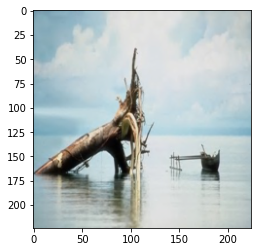

In [33]:
#Checking out some of the predications

test_image_id = 9

def denormalize(tensor):
  tensor = tensor*std + mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img, 0,1)
  plt.imshow(img)

def get_corel1500_class(id) :
  corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food',
                     'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
                                 
  return corel1500_classes[id]

show_img(images[test_image_id])                                  
print(get_corel1500_class(pred[test_image_id]))


africa


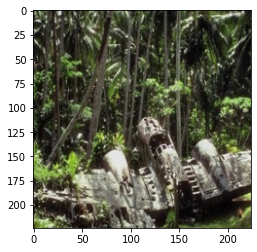

In [35]:
#Checking out some of the predications

test_image_id = 19

def denormalize(tensor):
  tensor = tensor*std + mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img, 0,1)
  plt.imshow(img)

def get_corel1500_class(id) :
  corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food',
                     'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
                                 
  return corel1500_classes[id]

show_img(images[test_image_id])                                  
print(get_corel1500_class(pred[test_image_id]))

africa


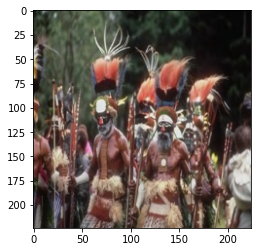

In [36]:
#Checking out some of the predications

test_image_id = 29

def denormalize(tensor):
  tensor = tensor*std + mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img, 0,1)
  plt.imshow(img)

def get_corel1500_class(id) :
  corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food',
                     'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
                                 
  return corel1500_classes[id]

show_img(images[test_image_id])                                  
print(get_corel1500_class(pred[test_image_id]))

africa


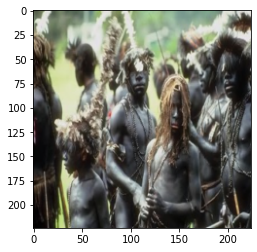

In [37]:
#Checking out some of the predications

test_image_id = 23

def denormalize(tensor):
  tensor = tensor*std + mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img, 0,1)
  plt.imshow(img)

def get_corel1500_class(id) :
  corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food',
                     'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
                                 
  return corel1500_classes[id]

show_img(images[test_image_id])                                  
print(get_corel1500_class(pred[test_image_id]))

beach


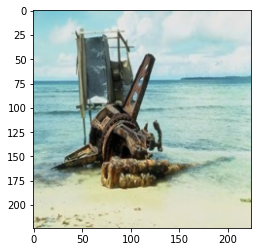

In [38]:
#Checking out some of the predications

test_image_id = 3

def denormalize(tensor):
  tensor = tensor*std + mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img, 0,1)
  plt.imshow(img)

def get_corel1500_class(id) :
  corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food',
                     'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
                                 
  return corel1500_classes[id]

show_img(images[test_image_id])                                  
print(get_corel1500_class(pred[test_image_id]))

# Viewing Images and normalization  - Under the Hood

In [39]:
#what's stored in pred
pred #tensor with values stored for first batch of images

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2])

In [40]:
images.size()

torch.Size([64, 3, 224, 224])

In [41]:
images[0].size() #dimensions for fist image

torch.Size([3, 224, 224])

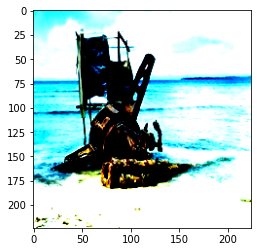

In [46]:
plt.imshow(np.clip(np.transpose(images[test_image_id], (1,2,0)), 0,1)) #imshow from matplotlib

In [0]:
z = (x - mean) / std

In [0]:
def denormalize(tensor):
  tensor = tensor * std + mean
  return tensor

In [0]:
def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img, 0,1)
  plt.imshow(img)


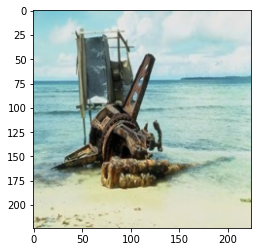

In [50]:
show_img(images[test_image_id])

In [0]:
def get_corel1500_class(id) :
  corel1500_classes = ['africa', 'beach', 'buses', 'cave', 'dinosaurs', 'elephants', 'food',
                     'horses', 'models', 'mountains', 'Roses', 'sunset', 'tallbuilding', 'tiger', 'vintage art']
                                 
  return corel1500_classes[id]


In [52]:
get_corel1500_class(pred[test_image_id])

'beach'

# Accuracy of the Model

In [0]:
#To find out accuracy of model over more image, so far it seems pretty correct on most of the images
model.eval() #as our model has a dropout layer so we need to use model.eval
with torch.no_grad():      #we don't need to calculate any of the gradients

  num_correct = 0   # stores values where predicted value == labels/actual value
  total = 0         #it will track the number of images we are testing

  cnt = 0

  #set_trace()

  for images, labels in testloader:                                                         #we are getting images and labels from test folder

    logps = model(images)                                                                    # then we do forward pass through the model and predictions are stored in logps
    output = torch.exp(logps)                                         #values of prediction in logps are logps are "log" values , so if we need probabilities we need to take exponenet of these values

    pred = torch.argmax(output, 1)
    total += labels.size(0)

    cnt += 1

    #if cnt>0 :
     # break    #to stop after one pass

     #each line below will corresponds to the probabilities the network predicts for one of those classes

In [54]:
pred, labels

(tensor([14, 14]), tensor([14, 14]))

In [55]:
pred == labels

tensor([True, True])

In [0]:
#if we want to pick the class with the highest probability all we need is to grab the index with highest value using argmax 

In [60]:
model.eval() #as our model has a dropout layer so we need to use model.eval
with torch.no_grad():      #we don't need to calculate any of the gradients

  num_correct = 0   # stores values where predicted value == labels/actual value
  total = 0         #it will track the number of images we are testing

  for batch, (images,labels) in enumerate(testloader,1):
                                                       #we are getting images and labels from test folder

    logps = model(images)                                                                    # then we do forward pass through the model and predictions are stored in logps
    output = torch.exp(logps)                                         #values of prediction in logps are logps are "log" values , so if we need probabilities we need to take exponenet of these values

    pred = torch.argmax(output, 1)
    total += labels.size(0)

    num_correct +=  (pred == labels).sum().item()

    print(f'Batch({ batch } / {len(testloader)})')

    #if you wanna stop after 5 batches then uncomment the code below

    #if batch == 5:
       #break

  print(f'Accuracy of model on {total} test images:  { num_correct * 100 / total} % ')


Batch(1 / 8)
Batch(2 / 8)
Batch(3 / 8)
Batch(4 / 8)
Batch(5 / 8)
Batch(6 / 8)
Batch(7 / 8)
Batch(8 / 8)
Accuracy of model on 450 test images:  97.55555555555556 % 


# Save the checkpoint
Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: image_datasets['train'].class_to_idx. You can attach this to the model as an attribute which makes inference easier later on.

model.class_to_idx = image_datasets['train'].class_to_idx

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, optimizer.state_dict. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = trainset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model) 

# Loading the checkpoint¶
At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 102)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

#model = load_checkpoint('checkpoint.pth')
#print(model)

# Inference for classification¶
Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called predict that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

In [67]:
pred, labels = predict(image_path, model)
print(pred)
print(labels)

NameError: ignored

# First you'll need to handle processing the input image such that it can be used in your network.

Image Preprocessing
You'll want to use PIL to load the image (documentation). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the thumbnail or resize methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy  array. You can reorder dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

# New Section
To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your process_image function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('flowers/test/1/image_06743.jpg')
imshow(image)